In [10]:
import os
import json
import time
import random
import requests
import pprint

import numpy as np
import pandas as pd

from PIL import Image
from ipyplot import plot_images
from google.cloud import storage
import cv2

API_ENDPOINT = f'http://{os.getenv("API_HOST")}:5000'
PROJECT_ID = "tcc-lucas-pierre"
BUCKET_NAME = "tcc-clothes"

In [11]:
performed_tasks = {}


def perform_task(params, endpoint):
    api_response = requests.post(f"{API_ENDPOINT}/{endpoint}", json=params).json()
    task_id = api_response["task_id"]

    status = "PENDING"
    print("Processing...")
    while status == "PENDING":
        time.sleep(3)
        response = requests.get(f"{API_ENDPOINT}/task/{task_id}").json()
        status = response["status"]
        print(status)

    performed_tasks[task_id] = {
        "params": params,
        "status": status,
    }

    if status != "SUCCESS":
        raise Exception(response)
    else:
        print("Task complete!")

    return task_id

In [12]:
from google.cloud import storage
from io import BytesIO
from PIL import Image


def download_blob_into_memory(blob_name):
    """Downloads a blob into memory."""
    storage_client = storage.Client()

    bucket = storage_client.bucket(BUCKET_NAME)

    blob = bucket.blob(blob_name)
    contents = blob.download_as_bytes()

    return contents

def draw_images(items, source_folder, sample=3):
    sample_items = random.sample(items, sample)

    images = []
    for item in sample_items:
        img_encoded = download_blob_into_memory(
            f'{source_folder}/{item["image_id"]}.jpg'
        )
        nparr = np.frombuffer(img_encoded, np.byte)
        image = cv2.imdecode(nparr, cv2.IMREAD_ANYCOLOR)
        images.append(image)
    plot_images(
        images,
        labels=[item["image_id"] for item in sample_items],
        custom_texts=[pprint.pformat(item) for item in sample_items],
        zoom_scale=1.0,
    )

In [13]:
LIMIT = 10
YEAR = 2012

payload = {
    "gender": "Men",
    "sub_category": "Shoes",
    "start_year": YEAR,
    "limit": LIMIT,
    "augmentation_config": {
        "albumentation": {
            "input_image": {"width": 60, "height": 80},
            "cropping": {"height": {"min": 10, "max": 70}},
            "resize": {"width": 256, "height": 256},
        }
    },
}

task_id = perform_task(payload, "filter")

Processing...
PENDING
PENDING
PENDING
PENDING
PENDING
PENDING
PENDING
PENDING
PENDING
PENDING
SUCCESS
Task complete!



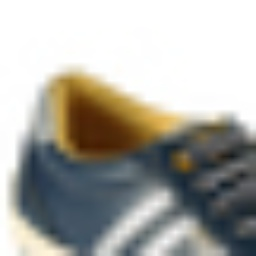


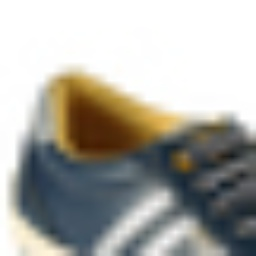

In [14]:
bucket_file = "fashion-tasks/" + task_id + "/metadata.json"
content = download_blob_into_memory(bucket_file)
metadata = json.loads(content)
draw_images(metadata, f"fashion-tasks/{task_id}/augmentation", sample=1)

## Inference: 

Run inference using the FashionNetVgg16NoBn from https://github.com/i008/pytorch-deepfashion.git on the original images in Step 1 or 2.

In [16]:
task_id = perform_task({"task_id": task_id}, "predict")
print(task_id)
# bucket_file = f"{task_id}/predictions.json"
# content = download_blob_into_memory(bucket_file)
# predictions = json.loads(content)

# print(f"Number of predictions: {len(predictions)}")
# print(
#     f'Prediction output per image: massive_attr-{len(predictions[0]["massive_attr"][0])}, categories-{len(predictions[0]["categories"][0])}'
# )

Processing...
SUCCESS
Task complete!
6740055409842051899
